<a href="https://colab.research.google.com/github/VladimirVladetic/DualModelAgeGenderPrediction/blob/main/GenderModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array
import zipfile
from keras.utils import to_categorical
from tensorflow.keras.regularizers import l1_l2, l1, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
import shutil
from google.colab import files

In [2]:
uploaded = files.upload()

source_path = '/content/kaggle.json'
destination_path = '/root/.kaggle/kaggle.json'
kaggle_dir = '/root/.kaggle/'
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)
os.rename(source_path, destination_path)

Saving kaggle.json to kaggle.json


In [3]:
! kaggle datasets download -d jangedoo/utkface-new

with zipfile.ZipFile('/content/utkface-new.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

folder_to_delete = '/content/sample_data'
shutil.rmtree(folder_to_delete)
folder_to_delete = '/content/crop_part1'
shutil.rmtree(folder_to_delete)
folder_to_delete = '/content/utkface_aligned_cropped'
shutil.rmtree(folder_to_delete)

100% 331M/331M [00:03<00:00, 122MB/s]
100% 331M/331M [00:03<00:00, 103MB/s]


In [4]:
def get_image_paths_age_gender_labels(image_directory):
    image_paths = []
    age_labels = []
    gender_labels = []
    for filename in tqdm(os.listdir(image_directory )):
        image_path = os.path.join(image_directory,filename)
        temporary_data = filename.split("_")
        age = int(temporary_data[0])
        gender = int(temporary_data[1])
        image_paths.append(image_path)
        age_labels.append(age)
        gender_labels.append(gender)
    return image_paths, age_labels, gender_labels

In [14]:
def plot_gender(df):
    plt.figure(figsize=(10, 5))
    gender_graph_labels = ['male', 'female']
    df['gender'].value_counts().plot(kind='bar', color=['blue', 'pink'])
    plt.title('Gender Distribution')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.xticks(range(len(gender_graph_labels)), gender_graph_labels, rotation=0)
    plt.show()

In [7]:
def extract_features(images, height, width):
    features = []
    for image in tqdm(images):
        var_img = load_img(image, color_mode='grayscale')
        var_img = var_img.resize((height,width), Image.ANTIALIAS)
        var_img = np.array(var_img)
        ## Normalization of images
        var_img = var_img / 255.0
        features.append(var_img)
    features = np.array(features)
    features = features.reshape(len(features), height, width, 1)
    ## from float64 to float32
    features = np.array(features, dtype=np.float32)
    return features

In [8]:
def create_model(input_shape):
    inputs = Input(input_shape)

    conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    batch_1 = BatchNormalization()(conv_1)
    conv_2 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(batch_1)
    batch_2 = BatchNormalization()(conv_2)

    maxpool_1 = MaxPooling2D(pool_size=(2,2))(batch_2)
    dropout_1 = Dropout(0.25)(maxpool_1)

    conv_3 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(dropout_1)
    batch_3 = BatchNormalization()(conv_3)
    conv_4 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(batch_3)
    batch_4 = BatchNormalization()(conv_4)

    maxpool_2 = MaxPooling2D(pool_size=(2,2))(batch_4)
    dropout_2 = Dropout(0.25)(maxpool_2)

    conv_5 = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(dropout_2)
    batch_5 = BatchNormalization()(conv_5)
    conv_6 = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(batch_5)
    batch_6 = BatchNormalization()(conv_6)

    maxpool_3 = MaxPooling2D(pool_size=(2,2))(batch_6)
    dropout_3 = Dropout(0.25)(maxpool_3)

    conv_7 = Conv2D(256, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(dropout_3)
    batch_7 = BatchNormalization()(conv_7)

    flatten = Flatten()(batch_7)

    dense_1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(flatten)

    dropout_1 = Dropout(0.3)(dense_1)

    dense_2 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(dropout_1)

    output = Dense(1, activation='sigmoid', name="gender_out")(dense_2)

    model = Model(inputs=[inputs], outputs=[output])
    return model

In [9]:
image_directory = "/content/UTKFace/"

image_paths, age_labels, gender_labels = get_image_paths_age_gender_labels(image_directory)

gender_dictionary = {0:"Male",1:"Female"}

  0%|          | 0/23708 [00:00<?, ?it/s]

In [10]:
df = pd.DataFrame()
df = pd.DataFrame({'image': image_paths, 'gender': gender_labels})

image_height = 128
image_width = 128
num_age_classes = 8

                                                   image  gender
0      /content/UTKFace/88_1_0_20170110183145045.jpg....       1
1      /content/UTKFace/24_1_4_20170103212802644.jpg....       1
2      /content/UTKFace/54_0_3_20170117191318186.jpg....       0
3      /content/UTKFace/35_1_0_20170105173525804.jpg....       1
4      /content/UTKFace/49_1_3_20170109012415373.jpg....       1
...                                                  ...     ...
23703  /content/UTKFace/26_1_2_20170116175506863.jpg....       1
23704  /content/UTKFace/20_0_3_20170117151020539.jpg....       0
23705  /content/UTKFace/26_0_4_20170117200038821.jpg....       0
23706  /content/UTKFace/38_1_1_20170116155827602.jpg....       1
23707  /content/UTKFace/28_1_4_20170117202544912.jpg....       1

[23708 rows x 2 columns]


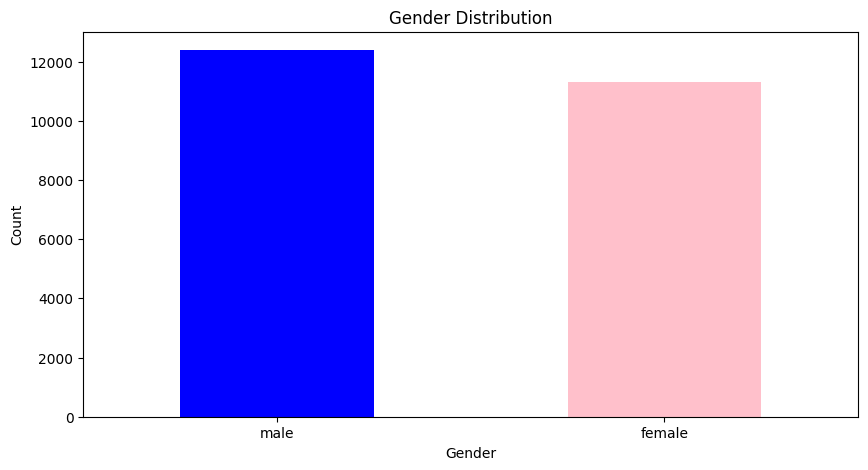

In [15]:
print(df)

plot_gender(df)

In [ ]:
X = extract_features(df["image"],image_height,image_width)

y_gender = np.array(df["gender"])

y_gender_tensor = tf.convert_to_tensor(y_gender, dtype=tf.float32)

input_shape = (image_height,image_width,1)

In [ ]:
print(len(X))
print(len(y_gender_tensor))

In [ ]:
plot_gender(df)

In [ ]:
opt = Adam(learning_rate=0.01)

model = create_model(input_shape, num_age_classes)

model.compile(loss="categorical_crossentropy", optimizer = opt, metrics='accuracy' )

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5)

history = model.fit(x=X, y=y_gender_tensor, batch_size=64, epochs=50, validation_split=0.2, callbacks=[lr_scheduler, early_stopping])

In [ ]:
gendermodel = load_model('gendermodel.h5')

In [ ]:
def extract_features_single_image(image_path, height, width):
    # Load and resize the image
    var_img = Image.open(image_path).convert('L')  # Convert to grayscale
    var_img = var_img.resize((height, width), Image.ANTIALIAS)

    # Convert the image to a numpy array
    var_img = np.array(var_img)

    # Normalize the image
    var_img = var_img / 255.0

    # Reshape the image to match the expected input shape
    var_img = var_img.reshape((1, height, width, 1)).astype(np.float32)

    return var_img

In [ ]:
image_path = "/content/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg"
height = 128
width = 128

In [ ]:
preprocessed_image = extract_features_single_image(image_path, height, width)

In [ ]:
gender_pred = gendermodel.predict(preprocessed_image)

1/1 [==============================] - 3s 3s/step


In [ ]:
print(gender_pred)

[[0.01909375]]
